<a href="https://colab.research.google.com/github/Firelok45/Dimplom/blob/main/TestPlanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage
from matplotlib.colors import ListedColormap
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def evristick(map, start, end, evr):
    x_s = start % len(map[0])
    y_s = start // len(map[0])
    x_e, y_e = end

    if evr == 0:  # Манхеттенская
        return math.fabs(x_e - x_s) + math.fabs(y_e - y_s)
    if evr == 1:  # Чебышева
        return max(math.fabs(x_e - x_s), math.fabs(y_e - y_s))
    else:  # Евклидова
        return math.sqrt((x_e - x_s)**2 + (y_e - y_s)**2)

def evristick_line(map, line, end, evr):
    new_line = np.zeros(len(line))
    for i in range(len(line)):
        new_line[i] = evristick(map, i, end, evr)
    return new_line

def table_of_map(map, speed, evr):
    height, width = map.shape
    weights = np.ones((height * width, height * width)) * np.inf
    for i in range(height):
        for j in range(width):
            if map[i][j] != 1:  # Если ячейка не является препятствием
                current_index = width * i + j
                weights[current_index][current_index] = 0
                resistance_coef = calculate_weight(speed)
                if j != width - 1 and map[i][j + 1] != 1:
                    weights[current_index][current_index + 1] = resistance_coef if map[i][j + 1] == 3 else 1
                if j != 0 and map[i][j - 1] != 1:
                    weights[current_index][current_index - 1] = resistance_coef if map[i][j - 1] == 3 else 1
                if i != 0 and map[i - 1][j] != 1:
                    weights[current_index][current_index - width] = resistance_coef if map[i - 1][j] == 3 else 1
                if i != height - 1 and map[i + 1][j] != 1:
                    weights[current_index][current_index + width] = resistance_coef if map[i + 1][j] == 3 else 1
                if evr in [1, 2]:
                    diag_weight = 1.41 if evr == 2 else 1
                    if i != height - 1 and j != width - 1 and map[i + 1][j + 1] != 1:
                        weights[current_index][current_index + width + 1] = diag_weight if map[i + 1][j + 1] == 0 else diag_weight * resistance_coef
                    if i != 0 and j != width - 1 and map[i - 1][j + 1] != 1:
                        weights[current_index][current_index - width + 1] = diag_weight if map[i - 1][j + 1] == 0 else diag_weight * resistance_coef
                    if i != height - 1 and j != 0 and map[i + 1][j - 1] != 1:
                        weights[current_index][current_index + width - 1] = diag_weight if map[i + 1][j - 1] == 0 else diag_weight * resistance_coef
                    if i != 0 and j != 0 and map[i - 1][j - 1] != 1:
                        weights[current_index][current_index - width - 1] = diag_weight if map[i - 1][j - 1] == 0 else diag_weight * resistance_coef
    return weights

def find_new_index(map, last_line, end, evr, heuristic_evaluation):
    line = np.copy(last_line)
    line[line == 0] = np.inf
    line_with_evr = line + heuristic_evaluation
    line_0 = np.sort(line_with_evr)
    for x in line_0:
        index = np.where(line_with_evr == x)[0][0]
        return index

def iteration_of_dijkstra(index, last_line, table):
  # Итерация Дейкстры
  new_line = np.copy(last_line)
  new_line[index] = 0
  last_step = last_line[index]

  for i in range(len(new_line)):
    if table[index, i] + last_step < new_line[i]:
      new_line[i] = table[index, i] + last_step

  return new_line

def A_star(map, table, start, end, evr):
    heuristic_evaluation = evristick_line(map, table[0], end, evr)
    line = np.ones(len(table)) * np.inf
    index = start
    line[start] = 0

    table_dijkstra = np.zeros([len(table)-1, len(table)])

    for i in range(len(line)-1):
        new_line = iteration_of_dijkstra(index, line, table)
        table_dijkstra[i] = new_line
        if index == end[0] * len(map[0]) + end[1]:
            break
        index = find_new_index(map, new_line, end, evr, heuristic_evaluation)
        line = new_line
    return table_dijkstra

def calculate_weight(speed_ratio):
    if speed_ratio >= 0.9 and speed_ratio <= 1.1:
      return 1
    else:
      return 1 / speed_ratio

def calculate_total_weight(map, way, speed):
    height, width = map.shape
    total_weight = 0
    for i in range(len(way) - 1):
        current_index = way[i]
        next_index = way[i + 1]
        current_x, current_y = current_index % width, current_index // width
        next_x, next_y = next_index % width, next_index // width
        if abs(current_x - next_x) + abs(current_y - next_y) == 1:  # прямой переход
            total_weight += calculate_weight(speed) if map[next_y][next_x] == 3 else 1
        else:  # диагональный переход
            total_weight += 1.41 * calculate_weight(speed) if map[next_y][next_x] == 3 else 1.41
    return total_weight

def find_new_ceng_from_zero(line, last_line):
    index_0 = np.where(line == 0)
    for x in index_0[0]:
        if last_line[x] - line[x]:
            return x

def find_way(table, start, end):
    index = end
    for i in range(len(table)):
        j = len(table) - i - 1
        if table[j][index] != 0:
            break

    way = [end]
    length = table[j][index]

    for i in range(j + 1):
        k = j - i
        if table[k][index] != length:
            index = find_new_ceng_from_zero(table[k + 1], table[k])
            length = table[k][index]
            way.append(index)
    way.append(start)
    return way

def A_star_final(map, start_coord, end_coord, speed, evr):
    table_1 = table_of_map(map, speed, evr)
    start_x, start_y = start_coord
    end_x, end_y = end_coord
    start = start_x + start_y * len(map[0])
    end = end_x + end_y * len(map[0])
    table_2 = A_star(map, table_1, start, end_coord, evr)
    way = find_way(table_2, start, end)
    total_weight = calculate_total_weight(map, way, speed)
    new_map = np.copy(map)
    for z in way:
        x = z % len(map[0])
        y = z // len(map[0])
        new_map[y, x] = 2
    cmap = ListedColormap(['black', 'gray', 'white', 'green'])
    plt.imshow(new_map, cmap = cmap)
    plt.show()
    return round(total_weight, 2)

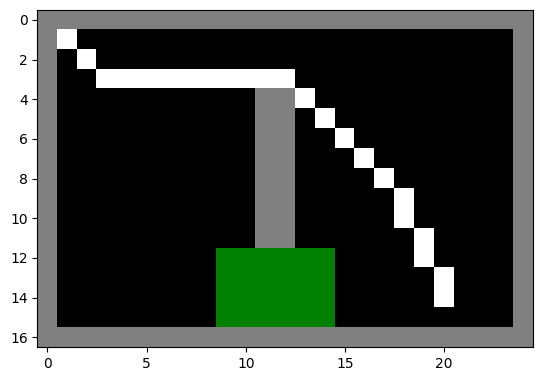

Эвристика 2: Итоговый вес маршрута = 26.1


In [ ]:
map_example = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

start_coord = (1, 1)
end_coord = (20, 14)
speed = 0.7

for evr in [2]:
    #print(table_of_map(map_example, evr))
    total_weight = A_star_final(map_example, start_coord, end_coord, speed, evr)
    print(f'Эвристика {evr}: Итоговый вес маршрута = {total_weight}')

In [ ]:
# Предполагаем, что у вас есть функции для сбора данных с лидара и распознавания поверхности
def get_lidar_data():
    # Собираем данные с лидара
    pass

def recognize_surface(data):
    # Используем нейросеть для распознавания типа поверхности
    pass

# Основной цикл работы робота
def main_loop(robot):
    map_size = (10, 10)  # Размер карты
    map_example = np.zeros(map_size)  # Карта
    speed_map_example = np.ones(map_size)  # Карта скоростей, начальное значение 1

    start_coord = (0, 0)
    end_coord = (9, 9)

    while not robot.is_task_completed():
        lidar_data = get_lidar_data()
        # Обновляем карту препятствий на основе данных с лидара
        map_example = update_map_with_lidar_data(map_example, lidar_data)

        current_speed = robot.get_speed()
        if current_speed < robot.get_normal_speed():
            surface_type = recognize_surface(surface_data)
           resistance_coef = calculate_weight(current_speed)
            # Обновляем карту скоростей в зависимости от типа поверхности
            update_speed_map(speed_map_example, robot.get_position(), speed_ratio)

        # Пересчитываем маршрут с учетом обновленной карты
        total_weight = A_star_final(map_example, speed_map_example, start_coord, end_coord, evr=2)
        print(f'Итоговый вес маршрута = {total_weight}')

        # Двигаемся по пересчитанному маршруту
        robot.move_to_next_position()

if __name__ == "__main__":
    robot = Robot()  # Предполагаем, что у вас есть объект класса Robot
    main_loop(robot)